In [1]:
import json
import os
import time
import sys

import cv2

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
IMG_SIZE = 500
BATCH_SIZE = 32

NEURONS = 32

NUM_KEYPOINTS = 16*2
EPOCHS = NUM_KEYPOINTS*10

BASE_LEARNING_RATE = 0.1

In [5]:
IMG_DIR = "datasets/mpii/images_selected/"
JSON = "datasets/mpii/trainval.json"

with open(JSON) as infile:
    json_data = json.load(infile)

json_dict = {i["image"]: i for i in json_data}

In [6]:
for k in json_dict.keys():
    for i in range(0,16):
        json_dict[k]['joints'][i].append(json_dict[k]['joints_vis'][i])
    del json_dict[k]['joints_vis']

In [7]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

In [8]:
def get(name):
    data = json_dict[name]
    img_data = plt.imread(IMG_DIR + data["image"])

    data["img_data"] = img_data
    #del img_data

    return data

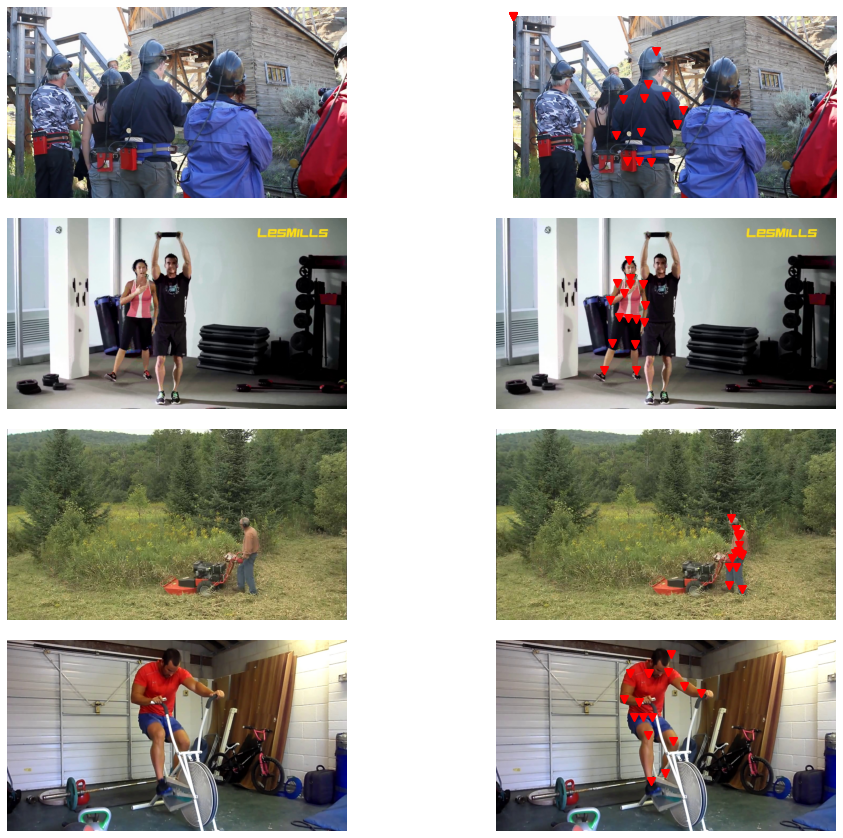

In [9]:

def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)


        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], c='red', marker="v", s=50, linewidths=2
                )
        else:
            current_keypoint = np.array(current_keypoint)
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                ax_all.scatter([x], [y], c='red', marker="v", s=50, linewidths=2)

    plt.tight_layout(pad=2.0)
    plt.show()


samples = list(json_dict.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get(sample)
    image = data["img_data"]
    keypoint = data["joints"]

    images.append(image)
    keypoints.append(keypoint)

visualize_keypoints(images, keypoints)

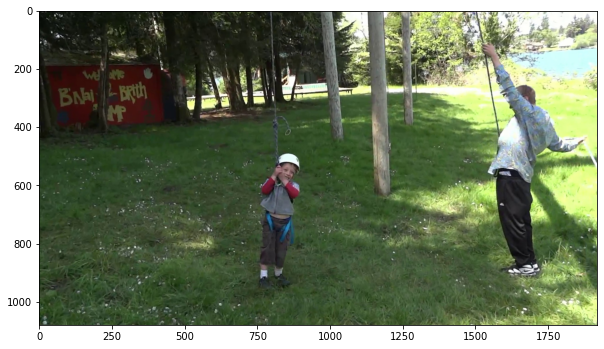

(16, 1080, 1920)


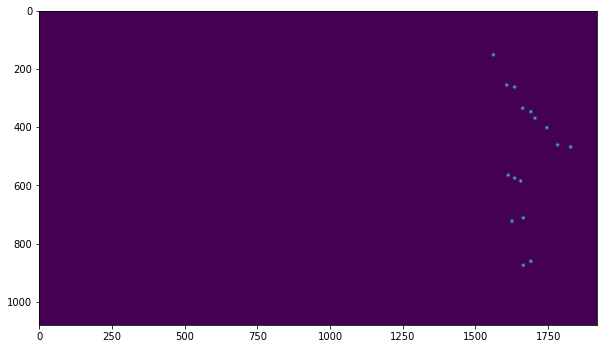

In [10]:
def gen_heatmaps(image, keypoints):
    heatmaps = np.zeros([int(NUM_KEYPOINTS/2), image.shape[0], image.shape[1]])
    
    k = 0
    for kp in keypoints:
        x, y = kp[0], kp[1]
        heatmaps[k, int(y), int(x)] = 1
        k += 1
        
    heatmaps_blurred = heatmaps.copy()
    for k in range(len(heatmaps)):
        if heatmaps_blurred[k].max() == 1:
            heatmaps_blurred[k] = cv2.GaussianBlur(heatmaps[k], (51, 51), 3)
            heatmaps_blurred[k] = heatmaps_blurred[k] / heatmaps_blurred[k].max()

    return heatmaps_blurred

def gen_heatmaps2(keypoints):
    heatmaps = np.zeros([IMG_SIZE, IMG_SIZE, int(NUM_KEYPOINTS/2)])
    
    k = 0
    for i in range(0,int(NUM_KEYPOINTS/2),2):
        x, y = keypoints[i], keypoints[i+1]
        if x < 0 or y < 0 or x >= IMG_SIZE or y >= IMG_SIZE:
            pass
        else:
            heatmaps[int(y), int(x), k] = 1
        k += 1
        
    heatmaps_blurred = heatmaps.copy()
    for k in range(0,int(NUM_KEYPOINTS/2)):
        if heatmaps_blurred[:,:,k].max() == 1:
            heatmaps_blurred[:,:,k] = cv2.GaussianBlur(heatmaps[:,:,k], (51, 51), 3)
            heatmaps_blurred[:,:,k] = heatmaps_blurred[:,:,k] / heatmaps_blurred[:,:,k].max()

    return heatmaps_blurred




def visualize_heatmaps(image, keypoints):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.show()
    
    res = np.zeros([image.shape[0], image.shape[1]])


    heatmaps = gen_heatmaps(image,keypoints)
    print(heatmaps.shape)
    
    plt.figure(figsize=(10, 10))
    for heatmap in heatmaps:
        
        res += heatmap
    plt.imshow(res)
    plt.show()
    
def visualize_heatmaps2(image, keypoints):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.show()
    
    res = np.zeros([IMG_SIZE, IMG_SIZE])


    heatmaps = gen_heatmaps2(keypoints)
    
    plt.figure(figsize=(10, 10))
    for i in range(0,int(NUM_KEYPOINTS/2)):
    
        res += heatmaps[:,:,i]
    
    plt.imshow(res)
    plt.show()


samples = list(json_dict.keys())
num_samples = 1
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get(sample)
    image = data["img_data"]
    keypoint = data["joints"]


    visualize_heatmaps(image, keypoint)

In [11]:
class KeyPointsDataset(tf.keras.utils.Sequence):
    
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")

        batch_keypoints = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, int(NUM_KEYPOINTS/2)), dtype="float32")

        for i, key in enumerate(image_keys_temp):
                        
            data = json_dict[key]
            img_data = plt.imread(IMG_DIR + data["image"])

            
            current_keypoint = np.array(data["joints"])[:, :2]
            kps = []

            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            kps_obj = KeypointsOnImage(kps, shape=img_data.shape)

            (new_image, new_kps_obj) = self.aug(image=img_data, keypoints=kps_obj)

            batch_images[i,] = new_image

            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))
            
     
            batch_keypoints[i,] = np.array(gen_heatmaps2(kp_temp))#.reshape(1, 1, NUM_KEYPOINTS)

            del data


        
        return (batch_images, batch_keypoints)

In [12]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)],
)

In [13]:
train_dataset = KeyPointsDataset(train_keys, train_aug)
validation_dataset = KeyPointsDataset(validation_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))

Total batches in training set: 464
Total batches in validation set: 82


In [14]:

def Conv(inputs,actual_neurons):
    x = tf.keras.layers.Conv2D(actual_neurons, kernel_size=3,padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(actual_neurons, kernel_size=3,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    return x


inputs = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, 3))
    
    
convd1 = Conv(inputs,NEURONS)

maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(convd1)
convd2 = Conv(maxpool,2*NEURONS)

maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(convd2)
convd3 = Conv(maxpool,4*NEURONS)

maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(convd3)
convd4 = Conv(convd3,8*NEURONS)

upsample1 = convd4
x = tf.keras.layers.Concatenate()([upsample1,convd3])
convup1 = Conv(x,4*NEURONS)

upsample2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(convup1)
x = tf.keras.layers.Concatenate()([upsample2,convd2])
convup2 = Conv(x,2*NEURONS)

upsample3 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(convup2)
x = tf.keras.layers.Concatenate()([upsample3,convd1])
convup3 = Conv(x,NEURONS)

outputs = tf.keras.layers.Conv2D(NUM_KEYPOINTS/2, kernel_size=3, padding='same')(convup3)


model = tf.keras.Model(inputs, outputs, name="keypoint_detector")

model.summary()

Model: "keypoint_detector"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 500, 500, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 500, 500, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                 

In [15]:
def custom_loss(y_true, y_pred):

    EPSILON=1e-6
    
    inter = tf.reduce_sum(y_true * y_pred)
    union = (
        tf.reduce_sum(y_true ** 2)
        + tf.reduce_sum(y_pred ** 2)
        - tf.reduce_sum(y_true * y_pred)
    )
    iou = (inter + EPSILON) / (union + EPSILON)
    iou = tf.reduce_mean(iou)
    return 1 - iou

In [16]:
# model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(BASE_LEARNING_RATE),metrics=['accuracy'], run_eagerly=True)
# model.compile(optimizer=tf.keras.optimizers.Adam(BASE_LEARNING_RATE), loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()], run_eagerly=True)
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])#, run_eagerly=True)
# model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(BASE_LEARNING_RATE),metrics=['mae'], run_eagerly=True)
model.compile(optimizer=tf.keras.optimizers.SGD(BASE_LEARNING_RATE), loss=custom_loss)

In [17]:
BACKBONE='heatmaps_mk2'

In [26]:
!mkdir -p training_ckp/{BACKBONE}
checkpoint_path = "training_ckp/"+BACKBONE+"/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

SAVE_PERIOD = 10

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                    verbose=1, 
                                                    save_weights_only=True,
                                                    save_freq='epoch',
                                                    #save_freq=int(SAVE_PERIOD * STEPS_PER_EPOCH),
                                                )

earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 20
                                                          , restore_best_weights = True)

!mkdir -p training_logs/{BACKBONE}
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=f"training_logs/{BACKBONE}/{time.time()}")

In [ ]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=EPOCHS,
                    callbacks=[
                                cp_callback,
                                earlystopping_callback,
                                tensorboard
                              ]
                   )

In [ ]:
!mkdir -p saved_model/{BACKBONE}
model.save(f'saved_model/{BACKBONE}/before_finetuning_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

get_ipython().system(f'mkdir -p saved_model/{BACKBONE}')
open(f"saved_model/{BACKBONE}/model.tflite", "wb").write(tflite_model)

